In [30]:
import tempfile
from pathlib import Path

import boto3
import pandas as pd

bucket = "ml-for-bem"
bucket_prefix = "hatchet"
experiment_id = "test/progressive-training-26"
experiment_id = "test/ma-lib-02"
experiment_id = "test/new-dockerfile-3"
experiment_id = "ma-webapp/v0"
experiment_id = "ma-webapp/test/v1-20250410-113041"
experiment_id = "ma-webapp/v1-20250410-135156"
experiment_id = "ma-webapp/test/v2-20250507-141804"
experiment_id = "ma-webapp/v2-20250507-151630"
experiment_id = "ma-webapp/test/v2-20250508-122929-boston-only"
experiment_id = "ma-webapp/test/v3-20250514-135900-boston-only"

s3 = boto3.client("s3")

# list all the files in the experiment directory that have "train" and "results" and "h5" in the key
files = s3.list_objects(Bucket=bucket, Prefix=f"{bucket_prefix}/{experiment_id}")[
    "Contents"
]

# filter the files to only include the ones that have "train" and "results" and "h5" in the key
train_err_h5_files = [
    file
    for file in files
    if "train/" in file["Key"] and "results" in file["Key"] and "h5" in file["Key"]
]


train_fold_err_keys = [file["Key"] for file in train_err_h5_files]

individual_fold_err_dfs = []
global_err_dfs = []
with tempfile.TemporaryDirectory() as temp_dir:
    for i, file in enumerate(train_fold_err_keys):
        local_path = Path(temp_dir) / f"result_{i}.h5"
        s3.download_file(Bucket=bucket, Key=file, Filename=local_path.as_posix())
        err_df = pd.read_hdf(local_path.as_posix(), key="stratum_metrics")
        global_err_df = pd.read_hdf(local_path.as_posix(), key="global_metrics")
        individual_fold_err_dfs.append(err_df)
        global_err_dfs.append(global_err_df)

individual_fold_err_dfs = pd.concat(individual_fold_err_dfs)
global_err_dfs = pd.concat(global_err_dfs)

train_pq_files = [file for file in files if "fold-averaged-errors" in file["Key"]]
train_pq_keys = [file["Key"] for file in train_pq_files]

fold_averaged_errs_df = pd.concat(
    [pd.read_parquet(f"s3://{bucket}/{key}").sort_index() for key in train_pq_keys],
    axis=1,
)

combined_sim_results_files = [
    file for file in files if "full-dataset.pq" in file["Key"]
]
final_combined_sim_results_key = combined_sim_results_files[-1]["Key"]
final_combined_sim_results_uri = f"s3://{bucket}/{final_combined_sim_results_key}"
combined_sim_results_df = pd.read_parquet(final_combined_sim_results_uri)

In [31]:
# combined_sim_results_df.to_parquet("E:/repos/carbon-signal-linear/data/sbem-v1.pq")

In [32]:
combined_sim_results_df.groupby("experiment_id").size()

experiment_id
ma-webapp/test/v3-20250514-135900-boston-only/iter-000/sample    49994
dtype: int64

Text(0.5, 0.98, 'Heating and Cooling Demand by Month')

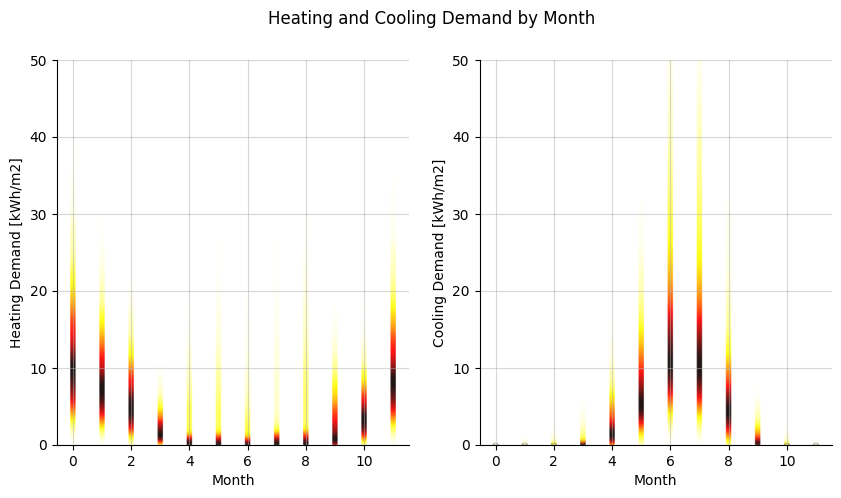

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

d = combined_sim_results_df["Energy"]["Raw"].sample(frac=0.1)


cmap = "hot_r"
h = d["Heating"]
h_max = h.max().max() * 1.1
c = d["Cooling"]
c_max = c.max().max() * 1.1
y_max = max(h_max, c_max)
y_max = 50
x = np.repeat(np.arange(12).reshape(1, -1), len(h), axis=0)

for i in range(12):
    ys = h.values[:, i]
    kde = gaussian_kde(ys)
    xs = np.linspace(0, y_max, 200)
    ax[0].scatter([i] * len(xs), xs, c=kde(xs), cmap=cmap, s=10, alpha=0.5)
ax[0].set_ylim(0, y_max)

x = np.repeat(np.arange(12).reshape(1, -1), len(c), axis=0)

for i in range(12):
    ys = c.values[:, i]
    kde = gaussian_kde(ys)
    xs = np.linspace(0, y_max, 200)
    ax[1].scatter([i] * len(xs), xs, c=kde(xs), cmap=cmap, s=10, alpha=0.5)
ax[1].set_ylim(0, y_max)
ax[0].set_ylabel("Heating Demand [kWh/m2]")
ax[1].set_ylabel("Cooling Demand [kWh/m2]")
ax[0].set_xlabel("Month")
ax[1].set_xlabel("Month")
ax[0].spines["top"].set_visible(False)
ax[1].spines["top"].set_visible(False)
ax[0].spines["right"].set_visible(False)
ax[1].spines["right"].set_visible(False)
# add faint gridlines
ax[0].grid(True, alpha=0.5)
ax[1].grid(True, alpha=0.5)
plt.suptitle("Heating and Cooling Demand by Month")


Month,4,5,6,7,8,9,10
mean,2.559128,2.771715,3.252933,2.122605,2.331956,4.288202,3.842408
50%,2.182973,0.761532,0.032514,0.000000,0.050373,0.096765,3.018301
75%,3.458893,4.624720,5.497590,3.172302,1.754563,7.465559,5.632792


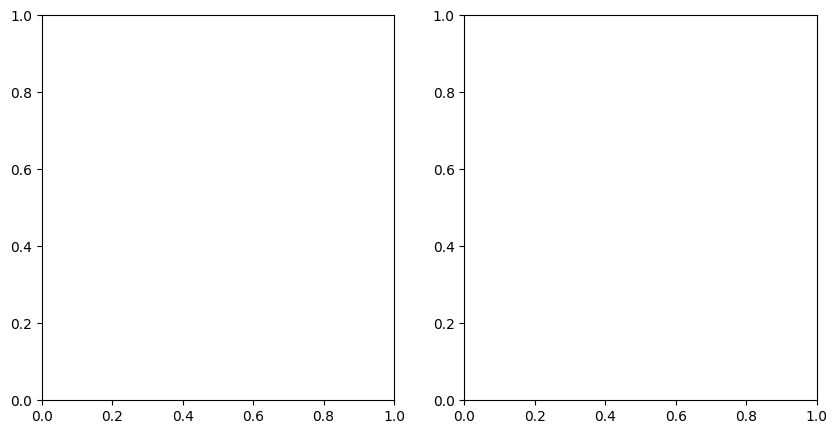

In [40]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

d = combined_sim_results_df["Energy"]["Raw"]
d["Heating"].reset_index(drop=True).describe()[[4, 5, 6, 7, 8, 9, 10]].loc[
    ["mean", "50%", "75%"]
]


Text(0.5, 0.98, 'Peak Heating and Cooling Demand by Month')

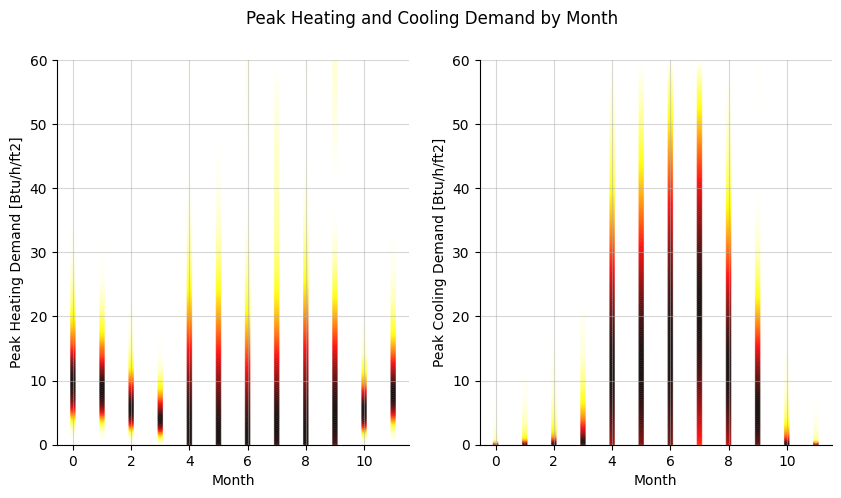

In [34]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

d = combined_sim_results_df["Peak"]["Raw"].sample(frac=0.1) * 1000 * 3.412 / 10.76391


cmap = "hot_r"
h = d["Heating"]
h_max = h.max().max() * 1.1
c = d["Cooling"]
c_max = c.max().max() * 1.1
y_max = max(h_max, c_max)
y_max = 60
x = np.repeat(np.arange(12).reshape(1, -1), len(h), axis=0)

for i in range(12):
    ys = h.values[:, i]
    kde = gaussian_kde(ys)
    xs = np.linspace(0, y_max, 200)
    ax[0].scatter([i] * len(xs), xs, c=kde(xs), cmap=cmap, s=10, alpha=0.5)
ax[0].set_ylim(0, y_max)

x = np.repeat(np.arange(12).reshape(1, -1), len(c), axis=0)

for i in range(12):
    ys = c.values[:, i]
    kde = gaussian_kde(ys)
    xs = np.linspace(0, y_max, 200)
    ax[1].scatter([i] * len(xs), xs, c=kde(xs), cmap=cmap, s=10, alpha=0.5)
ax[1].set_ylim(0, y_max)
ax[0].set_ylabel("Peak Heating Demand [Btu/h/ft2]")
ax[1].set_ylabel("Peak Cooling Demand [Btu/h/ft2]")
ax[0].set_xlabel("Month")
ax[1].set_xlabel("Month")
ax[0].spines["top"].set_visible(False)
ax[1].spines["top"].set_visible(False)
ax[0].spines["right"].set_visible(False)
ax[1].spines["right"].set_visible(False)
# add faint gridlines
ax[0].grid(True, alpha=0.5)
ax[1].grid(True, alpha=0.5)
plt.suptitle("Peak Heating and Cooling Demand by Month")


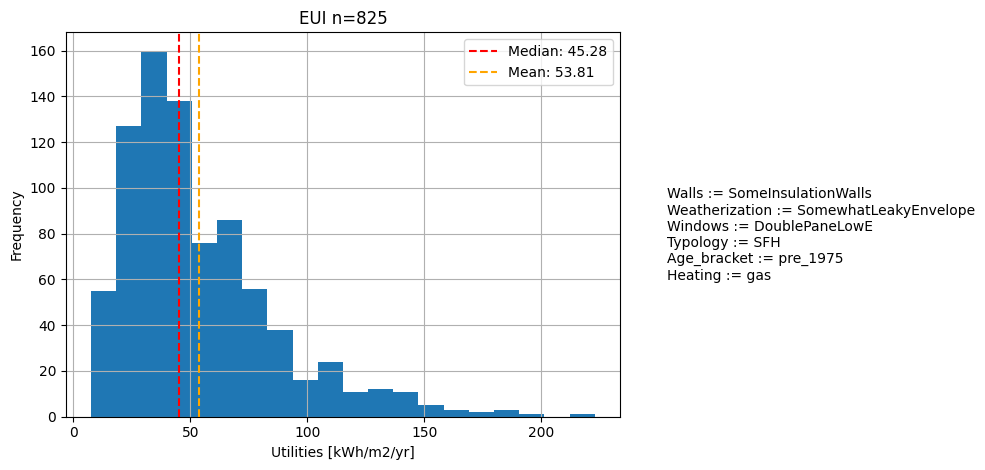

In [35]:
bins = 20
walls = "SomeInsulationWalls"
weatherization = "SomewhatLeakyEnvelope"
windows = "DoublePaneLowE"
# heating = "gas"
d = (
    combined_sim_results_df.xs(walls, level="feature.semantic.Walls")
    .xs(weatherization, level="feature.semantic.Weatherization")
    .xs(windows, level="feature.semantic.Windows")
    # .xs(typology, level="feature.semantic.Typology")
    # .xs(age_bracket, level="feature.semantic.Age_bracket")
    # .xs(thermostat, level="feature.semantic.Thermostat")
)
# mask = (
#     d.index.get_level_values("feature.semantic.Heating")
#     .str.lower()
#     .str.contains(heating)
# )
# d = d[mask]
# mask = ~d.index.get_level_values(
#     "feature.semantic.Distribution"
# ).str.lower().str.contains("uninsulated") & ~d.index.get_level_values(
#     "feature.semantic.Distribution"
# ).str.lower().str.contains("steam")
# d = d[mask]
# d = d["Energy"]["Utilities"]["NaturalGas"].sum(axis=1)
d = d["Energy"]["Raw"]["Heating"].sum(axis=1)
median = d.median()
mean = d.mean()
fig, ax = plt.subplots()
d.hist(bins=bins, ax=ax)
ax.axvline(median, color="red", linestyle="--", label=f"Median: {median:.2f}")
ax.axvline(mean, color="orange", linestyle="--", label=f"Mean: {mean:.2f}")
ax.set_xlabel("Utilities [kWh/m2/yr]")
ax.set_ylabel("Frequency")
ax.set_title(f"EUI n={len(d)}")
ax.legend()
# create whitespace to the right of the plot to add a longer text description of the semantic features in the plot
fig.text(
    1.05,
    0.5,
    f"Walls := {walls}\nWeatherization := {weatherization}\nWindows := {windows}\nTypology := {typology}\nAge_bracket := {age_bracket}\nHeating := {heating}",
    ha="left",
    va="center",
    wrap=False,
)
fig.tight_layout()


Text(0.5, 1.0, 'Percentage of Buildings with Peak Heating Demand in Each Month')

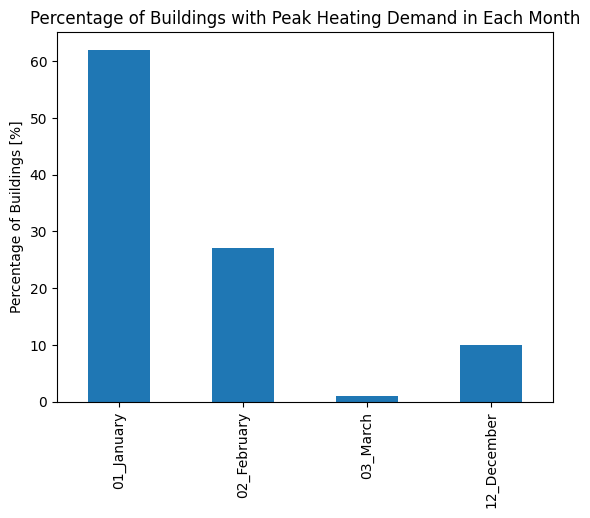

In [ ]:
fig, ax = plt.subplots()
(
    combined_sim_results_df["Peak"]["Raw"]["Heating"].idxmax(axis=1).value_counts()
    / len(combined_sim_results_df)
    * 100
).round().rename({
    1: "01_January",
    2: "02_February",
    3: "03_March",
    4: "04_April",
    5: "05_May",
    6: "06_June",
    7: "07_July",
    8: "08_August",
    9: "09_September",
    10: "10_October",
    11: "11_November",
    12: "12_December",
}).sort_index().plot.bar(ax=ax)
plt.ylabel("Percentage of Buildings [%]")
plt.title("Percentage of Buildings with Peak Heating Demand in Each Month")


## Checking Learning Curves

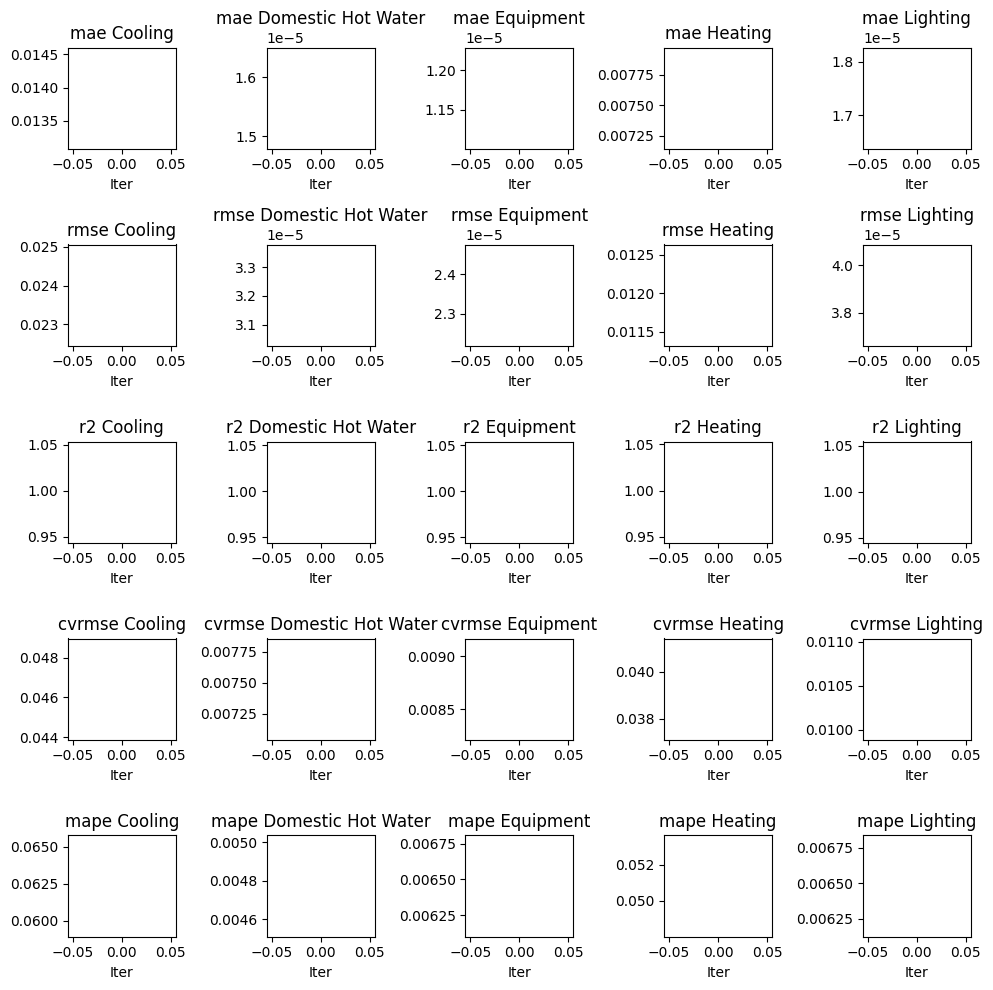

In [41]:
import matplotlib.pyplot as plt

global_errs = (
    global_err_dfs["test"].loc["Peak"].groupby("progressive_training_iter_ix").mean()
)
n_err_metrics = global_errs.columns.get_level_values("metric").nunique()
n_targets = global_errs.columns.get_level_values("target").nunique()
fig, ax = plt.subplots(n_err_metrics, n_targets, figsize=(10, 10))
for i, metric in enumerate(global_errs.columns.get_level_values("metric").unique()):
    for j, target in enumerate(global_errs.columns.get_level_values("target").unique()):
        global_errs[metric, target].plot(ax=ax[i, j])
        ax[i, j].set_title(f"{metric} {target}")
        ax[i, j].set_xlabel("Iter")
fig.tight_layout()

In [42]:
global_err_df.loc["Peak"].groupby("progressive_training_iter_ix").mean()["test"].stack(
    "metric"
).T

C:\Users\szvsw\AppData\Local\Temp\ipykernel_51180\1498660507.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  global_err_df.loc["Peak"].groupby("progressive_training_iter_ix").mean()["test"].stack(


progressive_training_iter_ix         0                                        
metric                          cvrmse       mae      mape        r2      rmse
target                                                                        
Cooling                       0.046418  0.013841  0.062342  0.998383  0.023757
Domestic Hot Water            0.007449  0.000016  0.004771  0.999093  0.000032
Equipment                     0.008690  0.000012  0.006453  0.999226  0.000023
Heating                       0.039261  0.007557  0.050821  0.998331  0.011975
Lighting                      0.010462  0.000017  0.006479  0.999573  0.000039

In [43]:
(
    individual_fold_err_dfs.loc["Peak"]["test"]
    .xs("mape", level="metric", axis=1)
    .xs("Heating", level="target", axis=1)
    .groupby("progressive_training_iter_ix")
    .mean()
    .T
    < 0.05
).mean()

progressive_training_iter_ix
0    0.666667
dtype: float64

In [44]:
individual_fold_err_dfs.loc["Peak"]["test"].xs("mape", level="metric", axis=1).xs(
    "Cooling", level="target", axis=1
).groupby("progressive_training_iter_ix").mean().T

progressive_training_iter_ix,0
stratum,
USA_MA_Boston-Hull.CG.Lightstation.726054_TMYx,0.060162
USA_MA_Boston-Logan.Intl.AP.725090_TMYx.2009-2023,0.060560
USA_MA_Boston.994971_TMYx.2009-2023,0.066303


In [45]:
fold_averaged_errs_df.xs("Peak", level="measurement").xs("r2", level="metric").groupby(
    "target"
).min().round(3)

,0
target,
Cooling,0.996
Domestic Hot Water,0.999
Equipment,0.999
Heating,0.998
Lighting,1.000


In [46]:
fold_averaged_errs_df.xs("Peak", level="measurement").xs("mae", level="metric").groupby(
    "target"
).max().round(4)

,0
target,
Cooling,0.0196
Domestic Hot Water,0.0000
Equipment,0.0000
Heating,0.0082
Lighting,0.0000


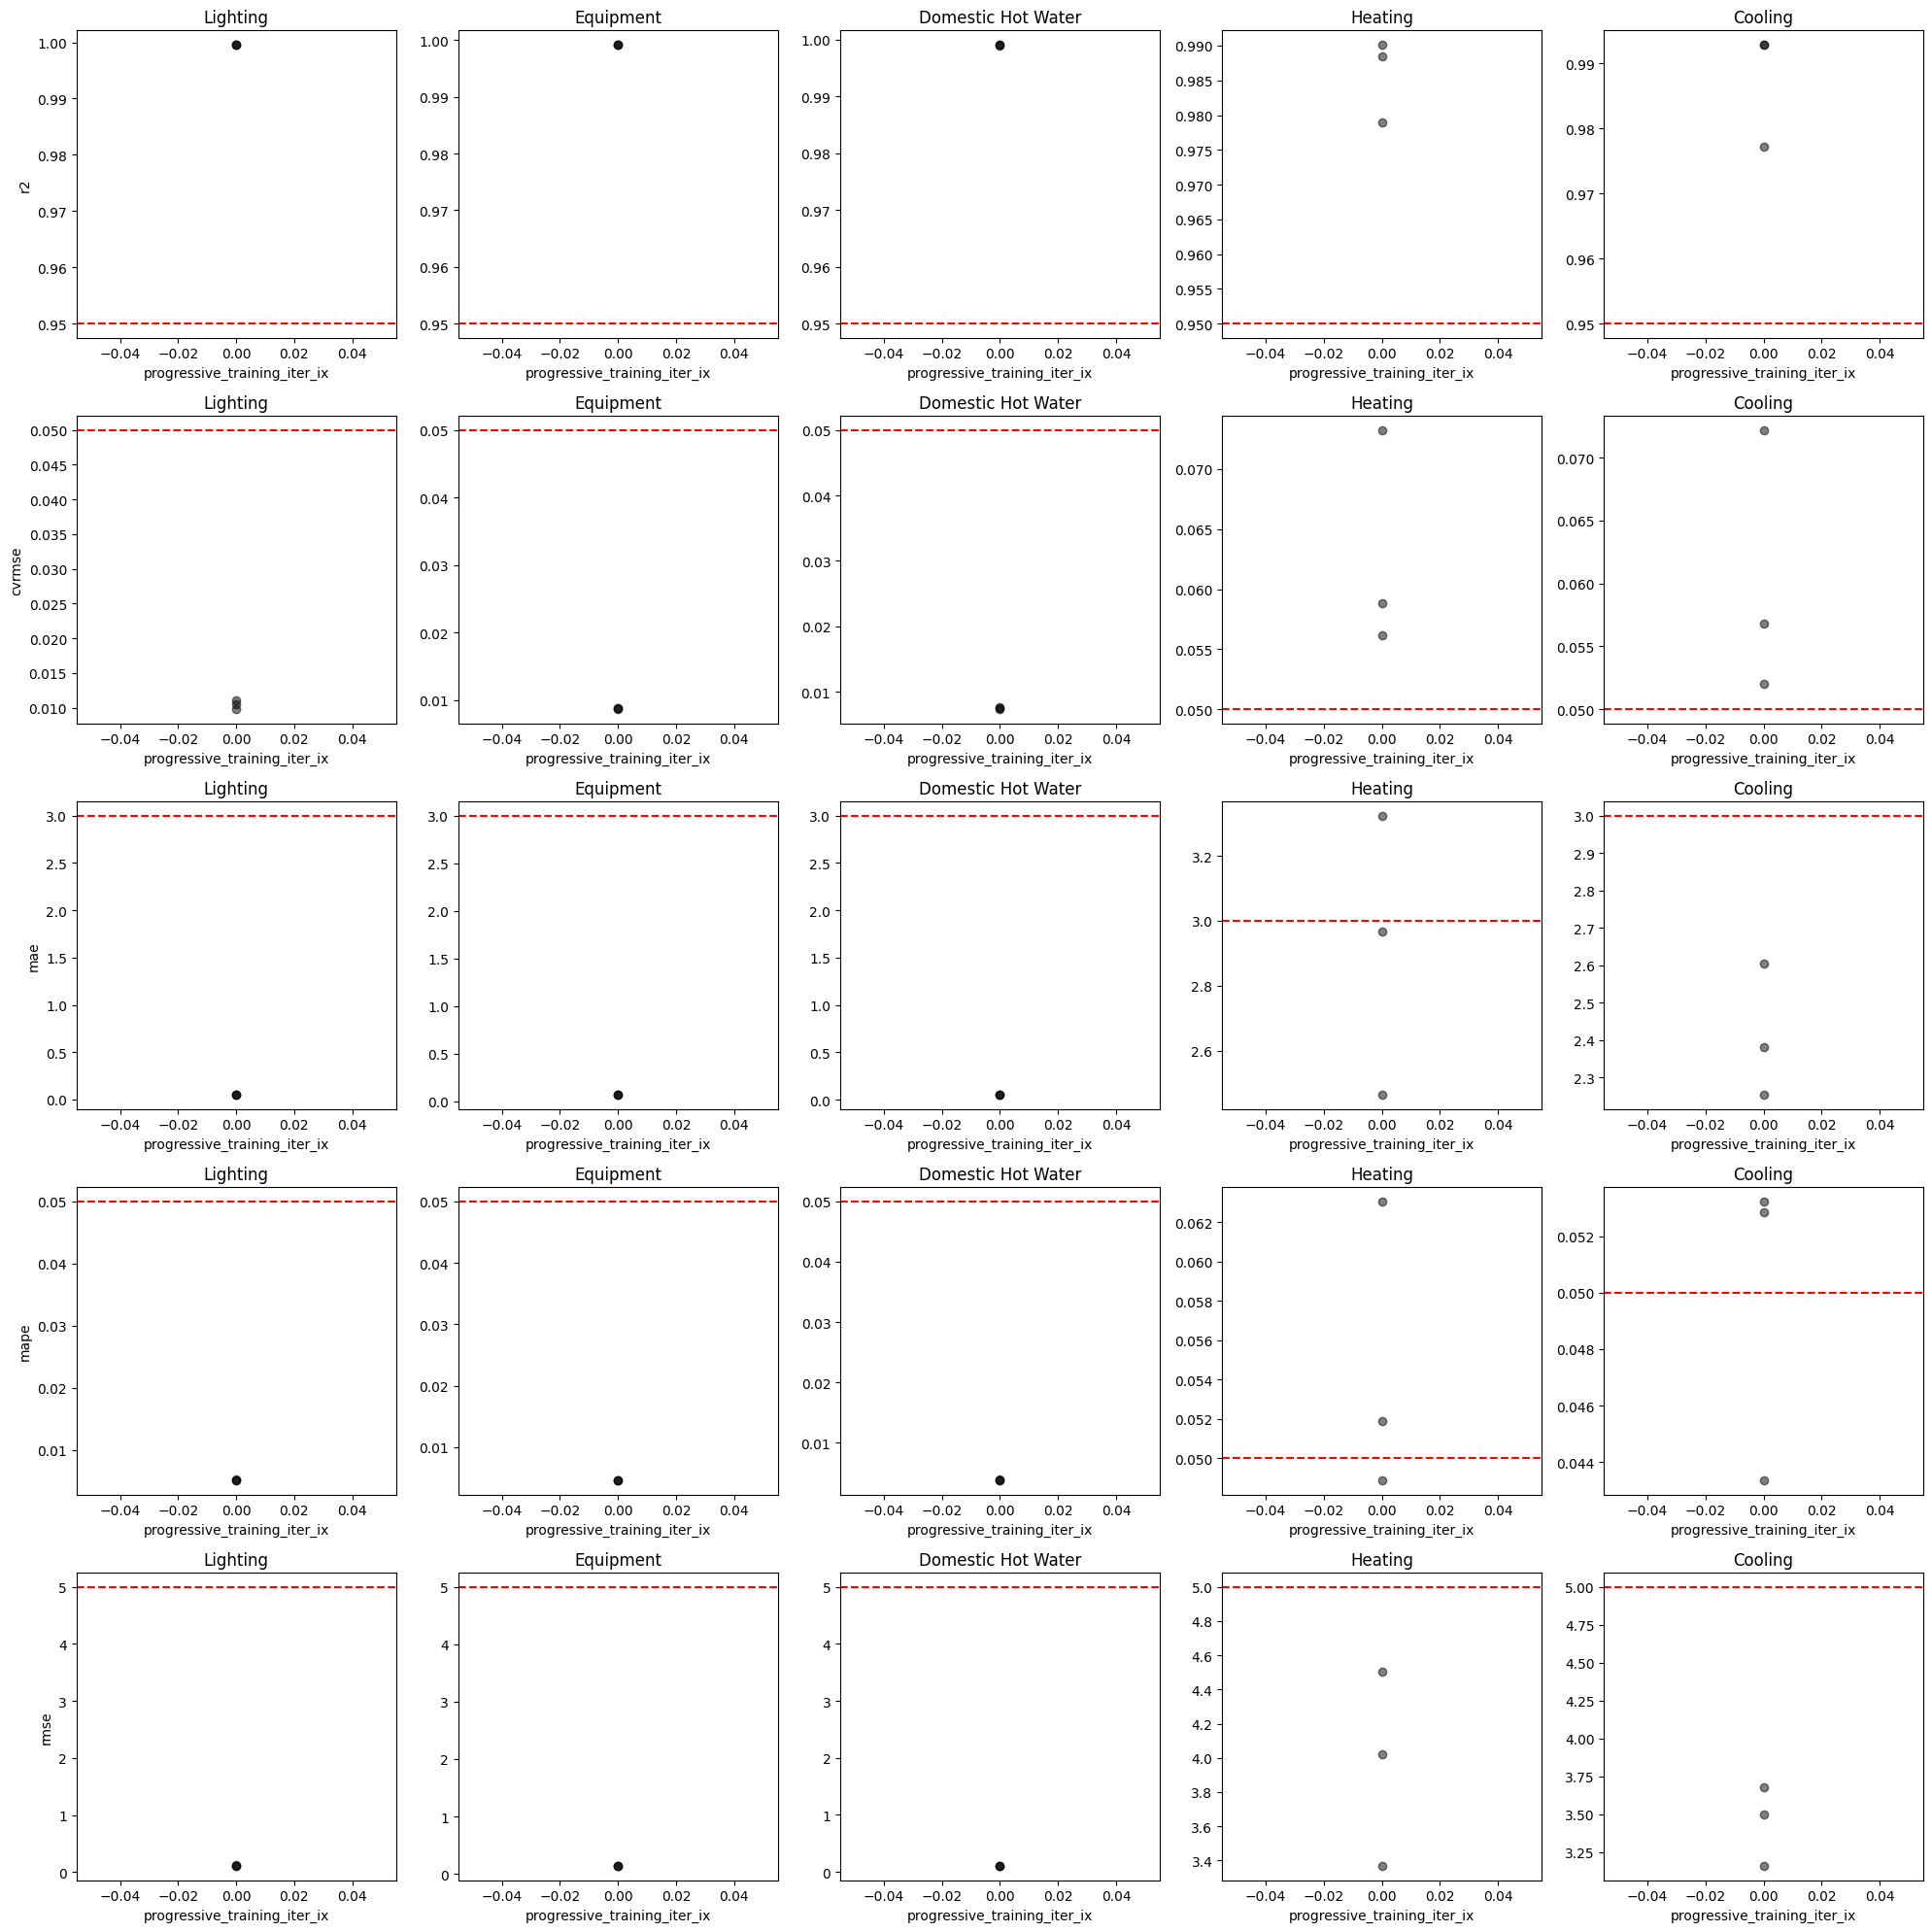

In [47]:
import matplotlib.pyplot as plt

threshes = {
    "mae": 3,
    "rmse": 5,
    "cvrmse": 0.05,
    "mape": 0.05,
    "r2": 0.95,
}
# threshes = {
#     "mae": 1,
#     "rmse": 1,
#     "cvrmse": 0.05,
#     "mape": 0.05,
#     "r2": 0.95,
# }
fig, axs = plt.subplots(5, 5, figsize=(20, 20))
for row_ix, metric in enumerate(["r2", "cvrmse", "mae", "mape", "rmse"]):
    for col_ix, target in enumerate([
        "Lighting",
        "Equipment",
        "Domestic Hot Water",
        "Heating",
        "Cooling",
    ]):
        ax = axs[row_ix, col_ix]
        errs = (
            individual_fold_err_dfs.loc["Energy"]
            .groupby("progressive_training_iter_ix")
            .mean()["test"]
            .xs(metric, level="metric", axis=1)
            .xs(target, level="target", axis=1)
        )
        ax.set_title(target)
        errs.plot(
            marker="o",
            lw=0,
            legend=False,
            ax=ax,
            color="black",
            alpha=0.5,
        )
        ax.axhline(threshes[metric], color="red", linestyle="--")
        if col_ix == 0:
            ax.set_ylabel(metric)
fig.tight_layout()

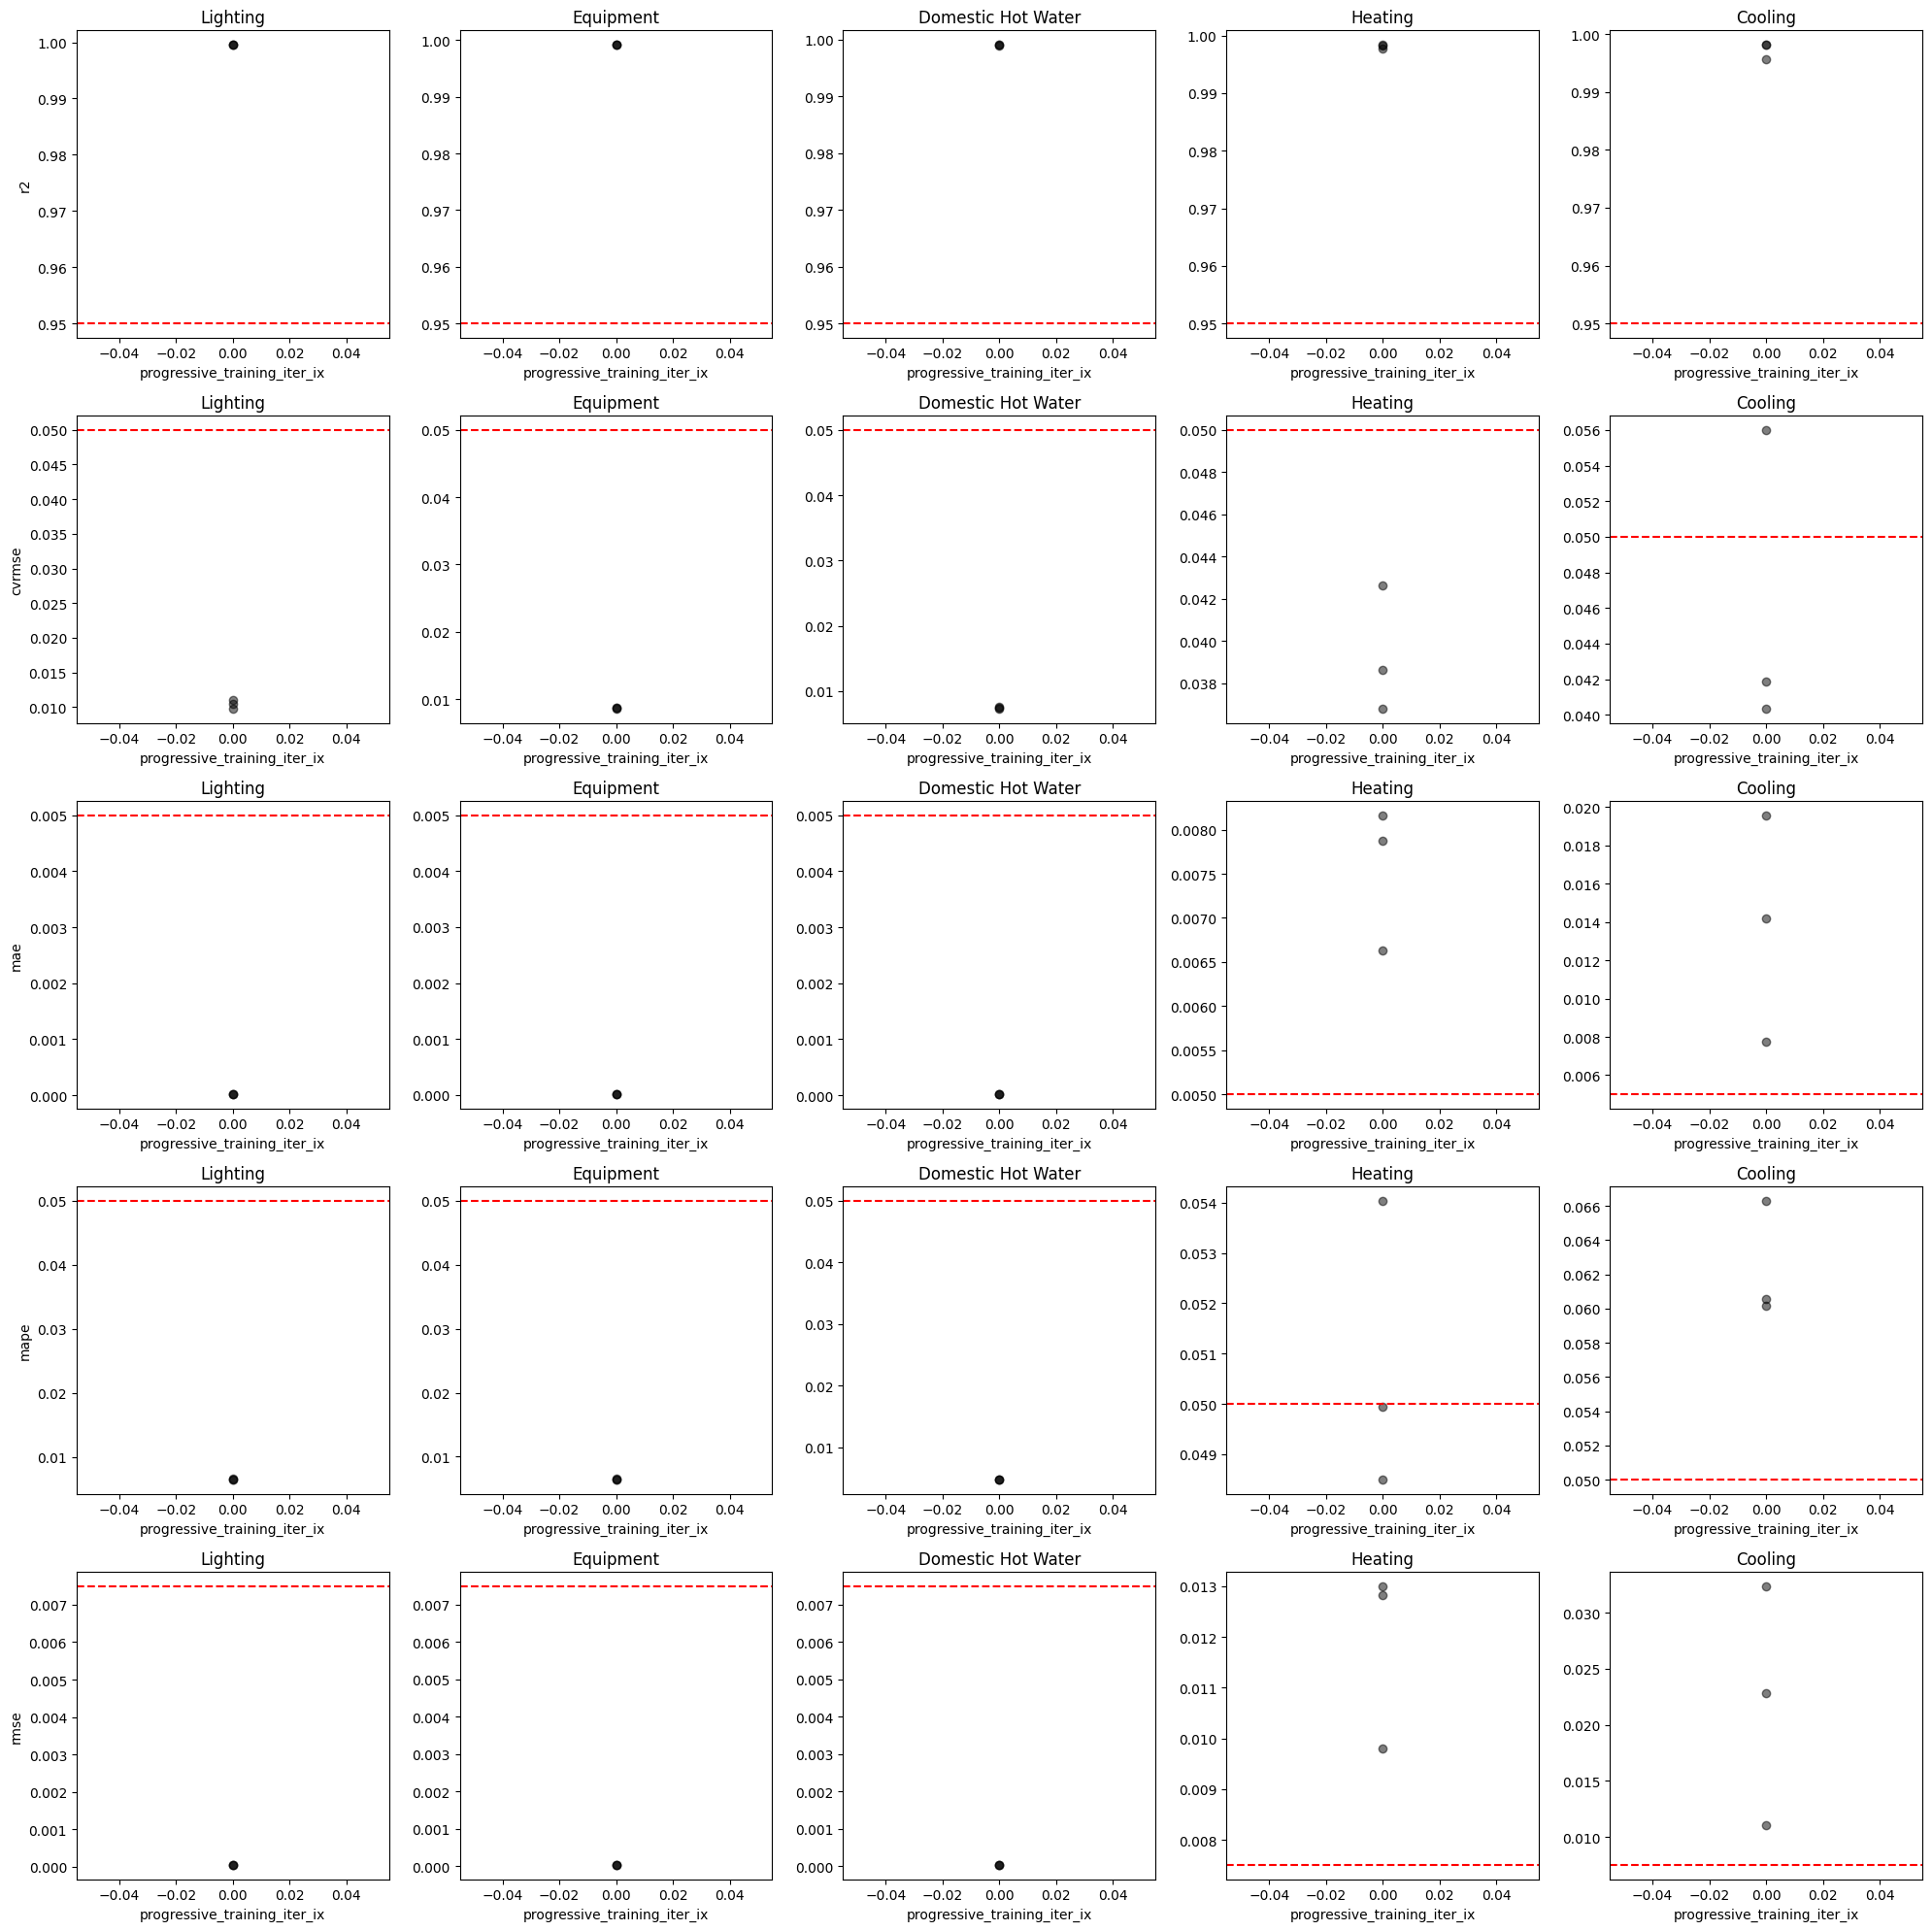

In [48]:
import matplotlib.pyplot as plt

threshes = {
    "mae": 0.005,
    "rmse": 0.0075,
    "cvrmse": 0.05,
    "mape": 0.05,
    "r2": 0.95,
}
# threshes = {
#     "mae": 1,
#     "rmse": 1,
#     "cvrmse": 0.05,
#     "mape": 0.05,
#     "r2": 0.95,
# }
fig, axs = plt.subplots(5, 5, figsize=(20, 20))
for row_ix, metric in enumerate(["r2", "cvrmse", "mae", "mape", "rmse"]):
    for col_ix, target in enumerate([
        "Lighting",
        "Equipment",
        "Domestic Hot Water",
        "Heating",
        "Cooling",
    ]):
        ax = axs[row_ix, col_ix]
        errs = (
            individual_fold_err_dfs.loc["Peak"]
            .groupby("progressive_training_iter_ix")
            .mean()["test"]
            .xs(metric, level="metric", axis=1)
            .xs(target, level="target", axis=1)
        )
        ax.set_title(target)
        errs.plot(
            marker="o",
            lw=0,
            legend=False,
            ax=ax,
            color="black",
            alpha=0.5,
        )
        ax.axhline(threshes[metric], color="red", linestyle="--")
        if col_ix == 0:
            ax.set_ylabel(metric)
fig.tight_layout()

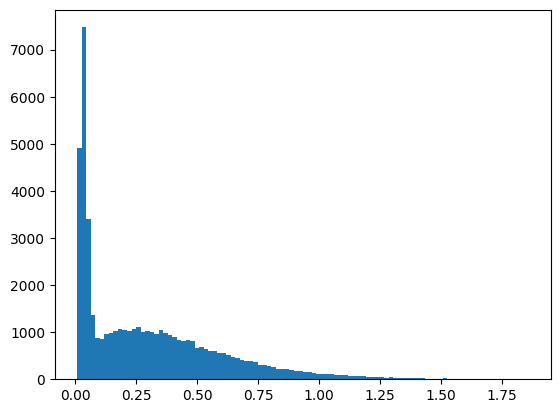

In [49]:
d = combined_sim_results_df["Peak"]["Raw"]["Heating"].max(axis=1).values.flatten()
d = d[d > 0]
_ = plt.hist(d, bins=100)

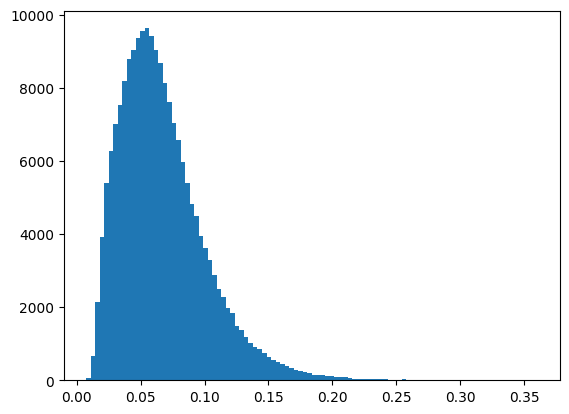

In [74]:
d = combined_sim_results_df["Peak"]["Raw"]["Heating"].max(axis=1).values.flatten()
d = d[d > 0]
_ = plt.hist(d, bins=100)

(np.float64(21.307190972609302), np.float64(19.47364254188657))

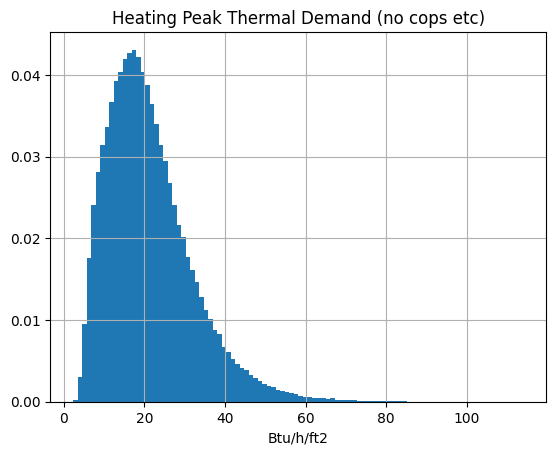

In [ ]:
plt.title("Heating Peak Thermal Demand (no cops etc)")
data = (
    combined_sim_results_df["Peak"]["Raw"]
    .T.groupby("Meter")
    .max()
    .T.reset_index(drop=True)["Heating"]
    * 1000  # W/kW
    * 3.412  # Btu/h/W
    / 10.76391  # ft2/m2
)
data.hist(bins=100, density=True)
plt.xlabel("Btu/h/ft2")
mean = data.mean()
median = data.median()
mean, median


(np.float64(118.21495306219282), np.float64(135.81838057148727))

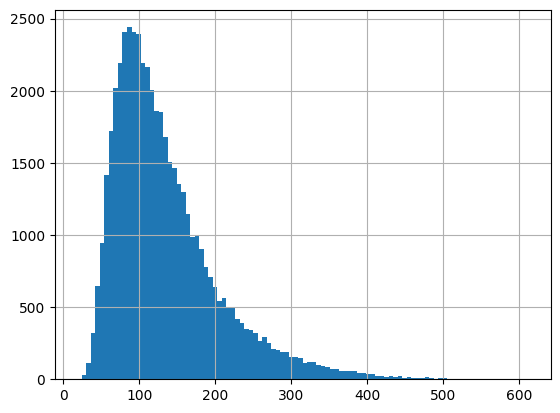

In [50]:
mask = combined_sim_results_df.index.get_level_values(
    "feature.weather.file"
).str.contains("Boston")

data = combined_sim_results_df.loc[(mask)]["Energy"]["Utilities"].sum(axis=1)
median = data.median()
mean = data.mean()
data.hist(bins=100)
median, mean


feature.semantic.Typology  feature.semantic.Walls             feature.semantic.Weatherization  feature.semantic.Thermostat
MFH                        FullInsulationWallsCavityExterior  TightEnvelope                    Controls                        27.627658
                           FullInsulationWallsCavity          TightEnvelope                    Controls                        28.828754
                           FullInsulationWallsCavityExterior  TightEnvelope                    NoControls                      32.584542
SFH                        FullInsulationWallsCavityExterior  TightEnvelope                    Controls                        32.586814
                           FullInsulationWallsCavity          TightEnvelope                    Controls                        32.902557
MFH                        FullInsulationWallsCavity          TightEnvelope                    NoControls                      33.524248
                           SomeInsulationWalls         

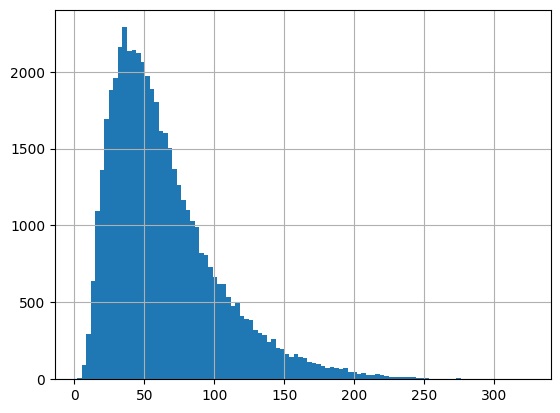

: 

In [ ]:
combined_sim_results_annual_raw = (
    combined_sim_results_df["Energy"]["Raw"].T.groupby("Meter").sum().T
)
combined_sim_results_annual_raw["Heating"].hist(bins=100)
combined_sim_results_annual_raw["Equipment"].groupby([
    "Typology",
    "Equipment",
    "Lighting",
]).std()
combined_sim_results_annual_raw["Heating"].groupby(["Typology"]).std()
combined_sim_results_annual_raw["Heating"].groupby([
    "feature.semantic.Typology",
    "feature.semantic.Walls",
    "feature.semantic.Weatherization",
    "feature.semantic.Thermostat",
]).mean().sort_values()

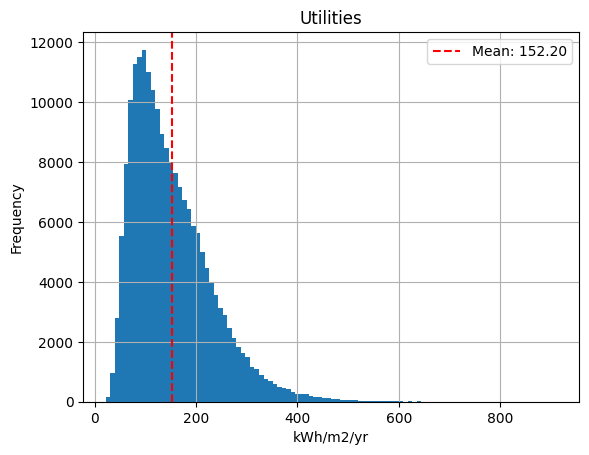

In [63]:
d = combined_sim_results_df["Energy"]["Utilities"].sum(axis=1)
fig, ax = plt.subplots()
d.hist(bins=100, ax=ax)
ax.axvline(d.mean(), color="red", linestyle="--", label=f"Mean: {d.mean():.2f}")
ax.set_xlabel("kWh/m2/yr")
ax.set_ylabel("Frequency")
ax.set_title("Utilities")
ax.legend()


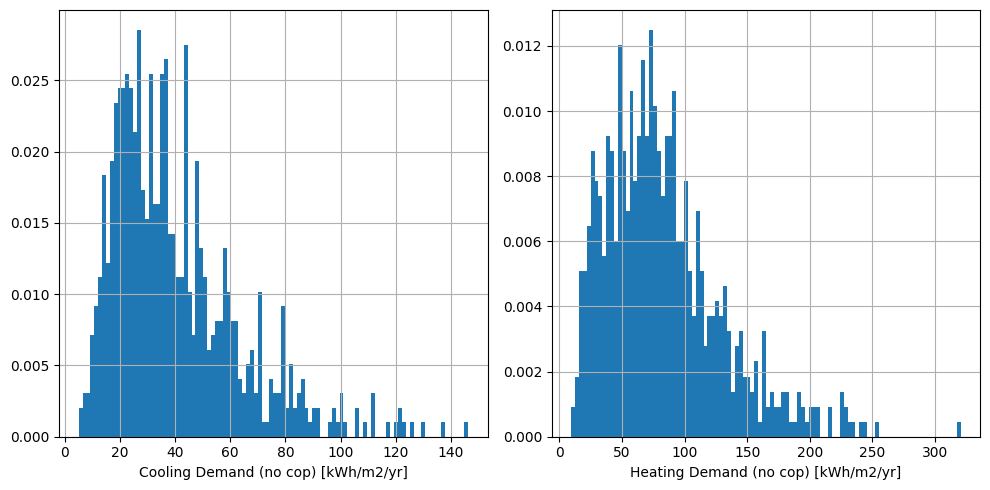

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
combined_sim_results_annual_raw["Cooling"].hist(bins=100, density=True, ax=ax[0])
ax[0].set_xlabel("Cooling Demand (no cop) [kWh/m2/yr]")

combined_sim_results_annual_raw["Heating"].hist(bins=100, density=True, ax=ax[1])
ax[1].set_xlabel("Heating Demand (no cop) [kWh/m2/yr]")
fig.tight_layout()


In [21]:
combined_sim_results_annual_raw.groupby("feature.semantic.Weatherization").mean()


Meter,Cooling,Domestic Hot Water,Equipment,Heating,Lighting
feature.semantic.Weatherization,,,,,
LeakyEnvelope,41.779376,13.725724,15.681872,120.276934,10.555347
SomewhatLeakyEnvelope,41.110673,13.938865,15.812550,85.735997,11.355602
TightEnvelope,37.740183,14.072804,15.788892,48.022681,10.834461


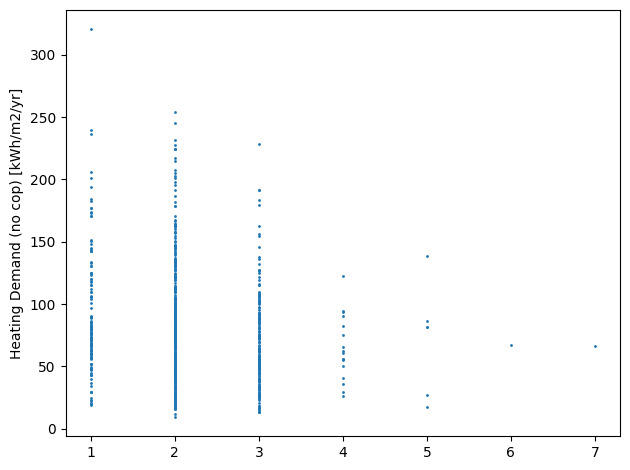

In [22]:
x = combined_sim_results_df.index.get_level_values("feature.geometry.num_floors").values
y = combined_sim_results_annual_raw["Heating"].values

fig, ax = plt.subplots()
ax.scatter(x, y, s=1)
# ax.set_xlabel("Total Conditioned Area [m2]")
ax.set_ylabel("Heating Demand (no cop) [kWh/m2/yr]")
# ax.set_xlim(0, 10000)
fig.tight_layout()


In [23]:
combined_sim_results_annual_raw.xs(
    "SomewhatLeakyEnvelope", level="feature.semantic.Weatherization"
).groupby([
    "feature.semantic.Age_bracket",
    "feature.semantic.Walls",
]).mean()["Heating"].sort_values()
# df.xs("USA_MA_Boston.994971_TMYx.2009-2023.zip", level="feature.weather.file").groupby(["feature.semantic.Typology", "feature.semantic.Age_bracket", "feature.semantic.Weatherization", ]).size()

feature.semantic.Age_bracket  feature.semantic.Walls           
post_2003                     FullInsulationWallsCavity             60.019365
                              FullInsulationWallsCavityExterior     61.153768
btw_1975_2003                 SomeInsulationWalls                   71.040979
                              FullInsulationWallsCavity             72.892255
pre_1975                      FullInsulationWallsCavityExterior     73.805795
post_2003                     SomeInsulationWalls                   79.425081
pre_1975                      FullInsulationWallsCavity             80.721860
btw_1975_2003                 FullInsulationWallsCavityExterior     83.243887
pre_1975                      SomeInsulationWalls                   86.525477
post_2003                     SIP                                   91.726207
pre_1975                      SIP                                   92.996046
post_2003                     UninsulatedWalls                      95.362601


In [24]:
combined_sim_results_annual_raw.groupby("feature.weather.file").mean()[
    "Heating"
].sort_values()

feature.weather.file
USA_MA_Boston.994971_TMYx.2009-2023                  68.903169
USA_MA_Boston-Logan.Intl.AP.725090_TMYx.2009-2023    89.124794
USA_MA_Boston-Hull.CG.Lightstation.726054_TMYx       89.941391
Name: Heating, dtype: float64

In [25]:
feats = combined_sim_results_df.index.to_frame(index=False)[
    [
        col
        for col in combined_sim_results_df.index.names
        if "feature" in col and "shading" not in col
    ]
]
feats.columns

Index(['feature.geometry.long_edge', 'feature.geometry.short_edge',
       'feature.geometry.orientation', 'feature.geometry.orientation.cos',
       'feature.geometry.orientation.sin', 'feature.geometry.aspect_ratio',
       'feature.geometry.wwr', 'feature.geometry.num_floors',
       'feature.geometry.f2f_height', 'feature.geometry.zoning',
       ...
       'feature.weather.monthly.dd_heating.11',
       'feature.weather.monthly.dd_heating.12',
       'feature.extra_spaces.basement.exists',
       'feature.extra_spaces.basement.occupied',
       'feature.extra_spaces.basement.conditioned',
       'feature.extra_spaces.basement.use_fraction',
       'feature.extra_spaces.attic.exists',
       'feature.extra_spaces.attic.occupied',
       'feature.extra_spaces.attic.conditioned',
       'feature.extra_spaces.attic.use_fraction'],
      dtype='object', length=145)

## Retraining

In [82]:
final_combined_sim_results_uri

's3://ml-for-bem/hatchet/ma-webapp/v2-20250507-151630/iter-000/sample/full-dataset.pq'

In [83]:
from epengine.models.train_sbem import TrainFoldSpec

spec = TrainFoldSpec(
    n_folds=5,
    data_uri=final_combined_sim_results_uri,
    stratification_field="feature.weather.file",
    progressive_training_iter_ix=0,
    experiment_id=experiment_id,
    sort_index=0,
    bucket="ml-for-bem",
)


In [84]:
train_features, train_targets = spec.train_segment
normalized_features = spec.normalize_params(train_features)
# for col in normalized_features.columns:
#     try:
#         col_vals = normalized_features[col].values.astype(float)
#         district_heating = train_targets["Heating"].values
#         correlation = np.corrcoef(col_vals, district_heating)[0, 1]
#         print(f"{col}: {correlation}")
#     except Exception as e:
#         print(type(col_vals))
#         print(f"{col} ERROR {e}")


In [85]:
train_features

np.float64(3.0001685487587104)

### LGB Curves

In [147]:
import lightgbm as lgb
import numpy as np
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score,
)
from tqdm.autonotebook import tqdm

train_features, train_targets = spec.train_segment
test_features, test_targets = spec.test_segment
train_features_norm = spec.normalize_params(train_features)
test_features_norm = spec.normalize_params(test_features)

all_iter_err_dfs = []
for frac in tqdm(np.linspace(0.1, 1.0, 19), total=39):
    iter_err_dfs = {}
    for end_use in ["Heating", "Cooling"]:
        n_train = int(len(train_features_norm) * frac)
        n_test = len(test_features_norm)
        lgb_train_data = lgb.Dataset(
            train_features_norm.sample(frac=1, random_state=42).iloc[:n_train],
            label=train_targets[end_use].sample(frac=1, random_state=42).iloc[:n_train],
        )
        lgb_test_data = lgb.Dataset(
            test_features_norm.sample(frac=1, random_state=42).iloc[:n_test],
            label=test_targets[end_use].sample(frac=1, random_state=42).iloc[:n_test],
        )

        lgb_params = {
            "objective": "regression",
            "metric": "rmse",
            # "max_depth": 5,
            # "learning_rate": 0.1,
            # "num_leaves": 100,
        }

        model = lgb.train(
            lgb_params,
            lgb_train_data,
            num_boost_round=4000,
            valid_sets=[lgb_test_data],
            valid_names=["eval"],
            callbacks=[lgb.early_stopping(20)],
        )

        test_preds = model.predict(test_features_norm)

        test_preds = pd.Series(test_preds, index=test_targets.index, name=end_use)
        test_trues = test_targets[end_use]

        residuals = test_trues - test_preds
        maes = {}
        mapes = {}
        r2s = {}
        cvrmses = {}
        for file in test_targets.index.get_level_values(
            "feature.weather.file"
        ).unique():
            test_trues_file = test_trues.xs(file, level="feature.weather.file")
            test_preds_file = test_preds.xs(file, level="feature.weather.file")
            mae = mean_absolute_error(test_trues_file, test_preds_file)
            mape = mean_absolute_percentage_error(test_trues_file, test_preds_file)
            r2 = r2_score(test_trues_file, test_preds_file)
            cvrmse = (
                np.sqrt(np.mean((test_trues_file - test_preds_file) ** 2))
                / test_trues_file.mean()
            )
            maes[file] = mae
            mapes[file] = mape
            r2s[file] = r2
            cvrmses[file] = cvrmse
        maes = pd.Series(maes, name="mae")
        mapes = pd.Series(mapes, name="mape")
        r2s = pd.Series(r2s, name="r2")
        cvrmses = pd.Series(cvrmses, name="cvrmse")
        iter_df = pd.concat([maes, mapes, r2s, cvrmses], axis=1)
        iter_df.index.name = "stratum"
        iter_df = iter_df.set_index(
            pd.Series([frac] * len(iter_df), name="frac"), append=True
        )
        iter_err_dfs[end_use] = iter_df
    iter_err_df = pd.concat(iter_err_dfs, axis=1, names=["metric"])
    all_iter_err_dfs.append(iter_err_df)

all_iter_err_dfs = pd.concat(all_iter_err_dfs, axis=0)
all_iter_err_dfs


159556 39919


KeyboardInterrupt: 

In [148]:
n_train, n_test

(159556, 39919)

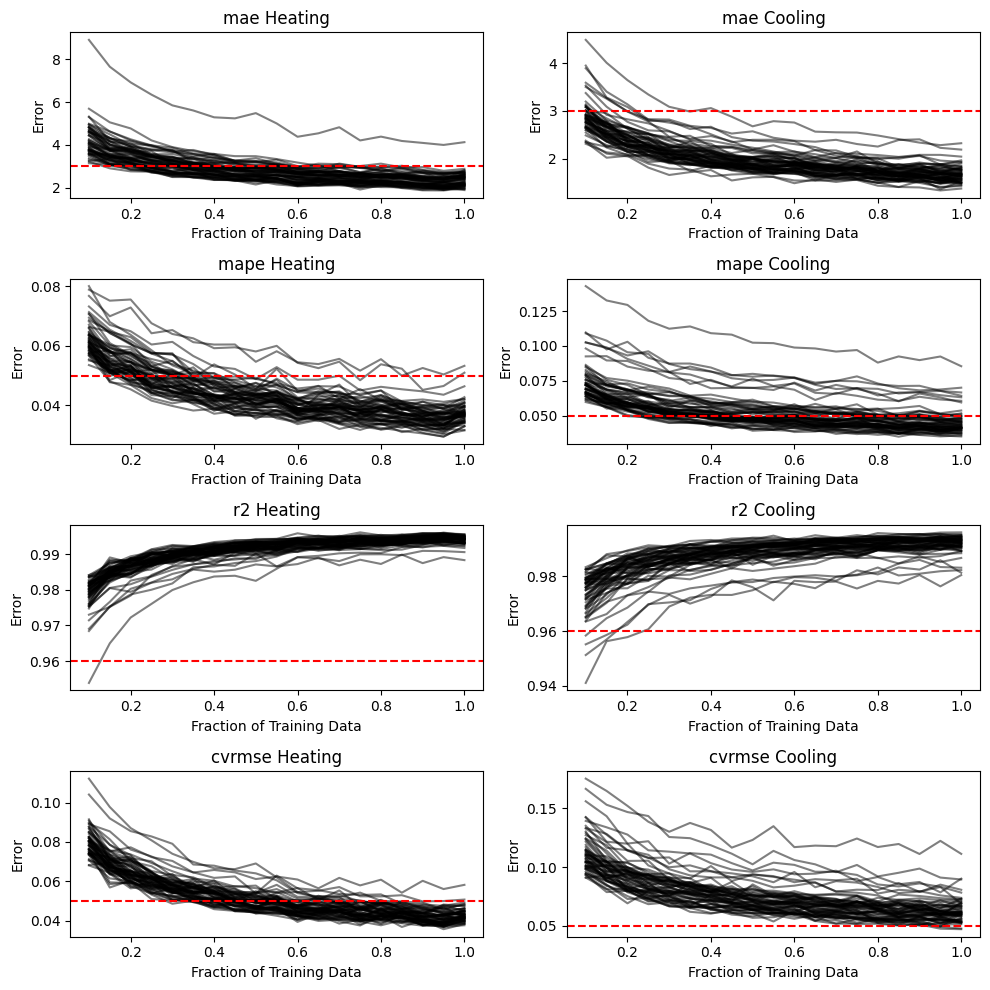

In [149]:
import matplotlib.pyplot as plt

threshes = {
    "mae": 3,
    "cvrmse": 0.05,
    "mape": 0.05,
    "r2": 0.96,
}
targets_to_plot = all_iter_err_dfs.columns.get_level_values(0).unique()
metrics_to_plot = all_iter_err_dfs.columns.get_level_values(1).unique()
fig, ax = plt.subplots(len(metrics_to_plot), len(targets_to_plot), figsize=(10, 10))
for i, metric in enumerate(metrics_to_plot):
    for j, target in enumerate(targets_to_plot):
        data_to_plot = all_iter_err_dfs.xs((target, metric), axis=1).unstack("stratum")
        data_to_plot.plot(ax=ax[i, j], legend=False, color="black", alpha=0.5)
        ax[i, j].axhline(threshes[metric], color="red", linestyle="--")
        ax[i, j].set_title(f"{metric} {target}")
        ax[i, j].set_xlabel("Fraction of Training Data")
        ax[i, j].set_ylabel("Error")
fig.tight_layout()

In [130]:
(
    len(
        spec.data.loc[
            spec.data.index.get_level_values("feature.geometry.short_edge") > 3
        ]
    ),
    len(spec.data),
)

(124587, 124587)

In [346]:
abs_errors = residuals.abs()
worst_semantic_features_fit = combined_sim_results_df.index.to_frame().loc[
    abs_errors.idxmax()
][
    [
        f
        for f in combined_sim_results_df.index.names
        if "feature.weather" not in f and "feature" in f
    ]
]
for feat, val in worst_semantic_features_fit.to_dict().items():
    print(feat, val)


feature.geometry.long_edge 5.271429784946954
feature.geometry.short_edge 3.701633178744034
feature.geometry.orientation 1.9927025937595322
feature.geometry.orientation.cos -0.4095003024173867
feature.geometry.orientation.sin 0.9123099814865936
feature.geometry.aspect_ratio 1.4240821633048883
feature.geometry.wwr 0.19633057497689138
feature.geometry.num_floors 22
feature.geometry.f2f_height 3.632544147914768
feature.geometry.zoning by_storey
feature.geometry.energy_model_conditioned_area 448.79668600172096
feature.geometry.energy_model_occupied_area 448.79668600172096
feature.geometry.attic_height 0.0
feature.geometry.shading_mask_00 0.0
feature.geometry.shading_mask_01 0.0
feature.geometry.shading_mask_02 0.0
feature.geometry.shading_mask_03 0.19065235328834984
feature.geometry.shading_mask_04 0.2358134957866958
feature.geometry.shading_mask_05 0.2187841647435257
feature.geometry.shading_mask_06 0.1979704124449433
feature.geometry.shading_mask_07 0.0
feature.geometry.shading_mask_08 0.

### LGB Full

In [88]:
import lightgbm as lgb
import numpy as np
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score,
)

dataset = "Peak"
train_features, train_targets = spec.train_segment
test_features, test_targets = spec.test_segment
train_targets = train_targets[dataset]
test_targets = test_targets[dataset]
train_features_norm = spec.normalize_params(train_features)
test_features_norm = spec.normalize_params(test_features)
errs_dfs = {}
meters = ["Domestic Hot Water", "Lighting", "Equipment", "Heating", "Cooling"]
meters = ["Heating"]
for end_use in meters:
    lgb_train_data = lgb.Dataset(
        train_features_norm,
        label=train_targets[end_use],
    )
    lgb_test_data = lgb.Dataset(
        test_features_norm,
        label=test_targets[end_use],
    )

    lgb_params = {
        "objective": "regression",
        "metric": "rmse",
        # "max_depth": 5,
        # "learning_rate": 0.1,
        # "num_leaves": 100,
    }

    model = lgb.train(
        lgb_params,
        lgb_train_data,
        num_boost_round=4000,
        valid_sets=[lgb_test_data],
        valid_names=["eval"],
        callbacks=[lgb.early_stopping(20)],
    )

    test_preds = model.predict(test_features_norm)

    test_preds = pd.Series(test_preds, index=test_targets.index, name=end_use)
    test_trues = test_targets[end_use]

    residuals = test_trues - test_preds
    maes = {}
    mapes = {}
    r2s = {}
    cvrmses = {}
    for file in test_targets.index.get_level_values("feature.weather.file").unique():
        test_trues_file = test_trues.xs(file, level="feature.weather.file")
        test_preds_file = test_preds.xs(file, level="feature.weather.file")
        mae = mean_absolute_error(test_trues_file, test_preds_file)
        mape = mean_absolute_percentage_error(test_trues_file, test_preds_file)
        r2 = r2_score(test_trues_file, test_preds_file)
        cvrmse = (
            np.sqrt(np.mean((test_trues_file - test_preds_file) ** 2))
            / test_trues_file.mean()
        )
        maes[file] = mae
        mapes[file] = mape
        r2s[file] = r2
        cvrmses[file] = cvrmse
    maes = pd.Series(maes, name="mae")
    mapes = pd.Series(mapes, name="mape")
    r2s = pd.Series(r2s, name="r2")
    cvrmses = pd.Series(cvrmses, name="cvrmse")
    iter_df = pd.concat([maes, mapes, r2s, cvrmses], axis=1)
    iter_df.index.name = "stratum"
    errs_dfs[end_use] = iter_df
    with open(f"model_{dataset}_{end_use.replace(' ', '_')}.lgb", "w") as f:
        f.write(model.model_to_string())

err_summary = pd.concat(errs_dfs, axis=1, names=["target"])


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19678
[LightGBM] [Info] Number of data points in the train set: 159821, number of used features: 190
[LightGBM] [Info] Start training from score 0.067215
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1968]	eval's rmse: 0.00258779


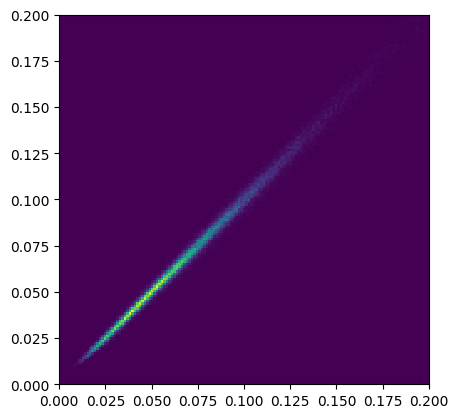

In [91]:
import matplotlib.pyplot as plt

end_use = "Heating"
with open(f"model_{dataset}_{end_use.replace(' ', '_')}.lgb") as f:
    model = lgb.Booster(model_str=f.read())
preds = model.predict(test_features_norm)
trues = test_targets[end_use]
_ = plt.hist2d(preds, trues, bins=np.linspace(0, 0.2, 150))
plt.gca().set_aspect("equal")


### Design Space

In [31]:
for k, v in spec.numeric_min_maxs.items():
    print(k, v)


feature.geometry.long_edge (np.float64(1.8587820232992796), np.float64(204.68179807521815))
feature.geometry.short_edge (np.float64(0.6891672242615761), np.float64(113.49737283820672))
feature.geometry.orientation (np.float64(-3.141582071355473), np.float64(3.1415757612439017))
feature.geometry.orientation.cos (np.float64(-0.9999999999440081), np.float64(0.9999999999897445))
feature.geometry.orientation.sin (np.float64(-0.9999999999962115), np.float64(0.9999999989522861))
feature.geometry.aspect_ratio (np.float64(1.0000031375464564), np.float64(10.810115012699804))
feature.geometry.wwr (np.float64(0.10000053553035589), np.float64(0.29999815390342977))
feature.geometry.num_floors (np.int64(1), np.int64(20))
feature.geometry.f2f_height (np.float64(2.5000164724717124), np.float64(3.9999856490795986))
feature.geometry.energy_model_conditioned_area (np.float64(3.0360651789362496), np.float64(63353.018979244065))
feature.geometry.energy_model_occupied_area (np.float64(3.0360651789362496), np

In [64]:
from epengine.models.transforms import (
    CategoricalFeature,
    ContinuousFeature,
    RegressorInputSpec,
)

feats = []
for feat in spec.train_segment[0].columns:
    if feat in spec.non_numeric_options:
        feats.append(
            CategoricalFeature(name=feat, values=spec.non_numeric_options[feat])
        )
    elif feat in spec.numeric_min_maxs:
        low, high = spec.numeric_min_maxs[feat]
        feats.append(ContinuousFeature(name=feat, min=float(low), max=float(high)))

ds = RegressorInputSpec(features=feats)
import yaml

with open("space.yml", "w") as f:
    yaml.dump(ds.model_dump(), f, indent=2, sort_keys=False)

[
    f.name
    for f in ds.features
    if "weather" not in f.name and "shading_mask" not in f.name
]
[f.name for f in ds.features if "weather" in f.name]


['feature.weather.file',
 'feature.weather.annual.daily_max_median',
 'feature.weather.annual.daily_median_median',
 'feature.weather.annual.daily_min_median',
 'feature.weather.annual.daily_range_median',
 'feature.weather.annual.dd_cooling',
 'feature.weather.annual.dd_heating',
 'feature.weather.latitude',
 'feature.weather.longitude',
 'feature.weather.monthly.daily_max.01',
 'feature.weather.monthly.daily_max.02',
 'feature.weather.monthly.daily_max.03',
 'feature.weather.monthly.daily_max.04',
 'feature.weather.monthly.daily_max.05',
 'feature.weather.monthly.daily_max.06',
 'feature.weather.monthly.daily_max.07',
 'feature.weather.monthly.daily_max.08',
 'feature.weather.monthly.daily_max.09',
 'feature.weather.monthly.daily_max.10',
 'feature.weather.monthly.daily_max.11',
 'feature.weather.monthly.daily_max.12',
 'feature.weather.monthly.daily_max_median.01',
 'feature.weather.monthly.daily_max_median.02',
 'feature.weather.monthly.daily_max_median.03',
 'feature.weather.month

In [58]:
ds = {
    "categorical": spec.non_numeric_options,
    "continuous": {
        k: (float(low), float(high)) for k, (low, high) in spec.numeric_min_maxs.items()
    },
    "params": sorted(
        list(spec.non_numeric_options.keys()) + list(spec.numeric_min_maxs.keys()),
        key=lambda x: spec.train_segment[0].columns.tolist().index(x),
    ),
}
import json

print(json.dumps(ds, indent=4))


{
    "categorical": {
        "feature.geometry.zoning": [
            "by_storey",
            "core/perim"
        ],
        "feature.semantic.DHW": [
            "ElectricResistanceDHW",
            "HPWH",
            "NaturalGasDHW",
            "NaturalGasHeatingDHWCombo"
        ],
        "feature.semantic.Walls": [
            "FullInsulationWallsCavity",
            "FullInsulationWallsCavityExterior",
            "SIP",
            "SomeInsulationWalls",
            "UninsulatedWalls"
        ],
        "feature.semantic.Region": [
            "MA"
        ],
        "feature.semantic.Cooling": [
            "ACCentral",
            "ACWindow",
            "ASHPCooling",
            "GSHPCooling",
            "WindowASHP"
        ],
        "feature.semantic.Heating": [
            "ASHPHeating",
            "ElectricResistance",
            "GSHPHeating",
            "NaturalGasCondensingHeating",
            "NaturalGasHeating",
            "OilHeating"
        ],
      

In [29]:
for k, v in spec.non_numeric_options.items():
    print(k, v)


feature.geometry.zoning ['by_storey', 'core/perim']
feature.semantic.DHW ['ElectricResistanceDHW', 'HPWH', 'NaturalGasDHW', 'NaturalGasHeatingDHWCombo']
feature.semantic.Walls ['FullInsulationWallsCavity', 'FullInsulationWallsCavityExterior', 'SIP', 'SomeInsulationWalls', 'UninsulatedWalls']
feature.semantic.Region ['MA']
feature.semantic.Cooling ['ACCentral', 'ACWindow', 'ASHPCooling', 'GSHPCooling', 'WindowASHP']
feature.semantic.Heating ['ASHPHeating', 'ElectricResistance', 'GSHPHeating', 'NaturalGasCondensingHeating', 'NaturalGasHeating', 'OilHeating']
feature.semantic.Windows ['DoublePaneLowE', 'SinglePane', 'SinglePaneStormWindows', 'TriplePaneLowE']
feature.semantic.Lighting ['LED', 'NoLED']
feature.semantic.Typology ['MFH', 'SFH']
feature.semantic.Equipment ['HighEfficiencyEquipment', 'LowEfficiencyEquipment']
feature.semantic.Thermostat ['Controls', 'NoControls']
feature.semantic.Age_bracket ['btw_1975_2003', 'post_2003', 'pre_1975']
feature.semantic.Distribution ['AirDuctsCon

<Axes: >

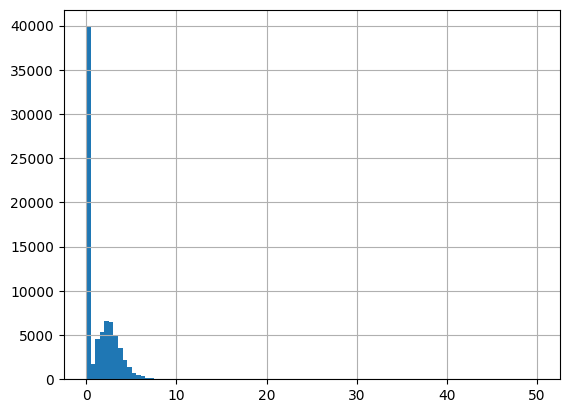

In [ ]:
train_features["feature.geometry.attic_height"].hist(bins=(np.linspace(0, 50, 100)))


np.float64(0.019093262256849226)

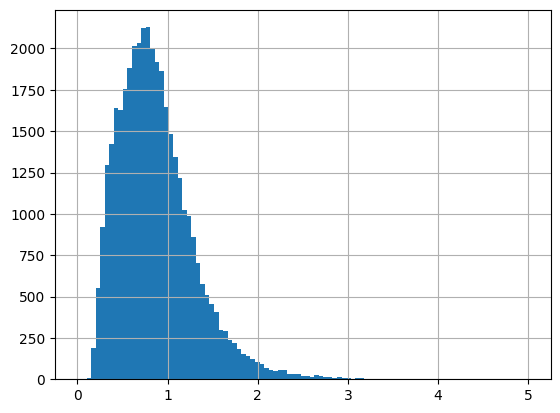

In [53]:
attic_heights = train_features["feature.geometry.attic_height"]
f2f_heights = train_features["feature.geometry.f2f_height"]
ratio = attic_heights / f2f_heights
ratio = ratio[ratio > 0]
ratio.hist(bins=np.linspace(0, 5, 100))
(ratio > 2).mean()


<Axes: >

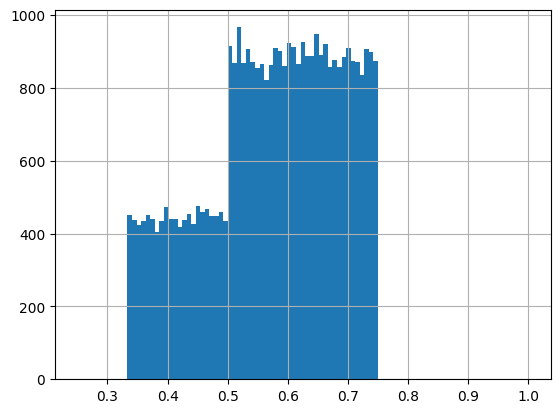

In [50]:
attic_heights = train_features["feature.geometry.attic_height"]
short_edges = train_features["feature.geometry.short_edge"] / 2
(attic_heights / short_edges).hist(bins=np.linspace(3 / 12, 12 / 12, 100))


# Old IDF File Stuff

In [145]:
import asyncio

from archetypal.idfclass import IDF
from epinterface.geometry import match_idf_to_building_and_neighbors

from epengine.models.shoebox import ShoeboxSimulationSpec

df_old = pd.read_parquet(
    "s3://ml-for-bem/hatchet/massachusetts/2024_09_30/residential-v2/specs/832ee29a-1a76-4126-9c83-f08171b5899a/832ee29a-1a76-4126-9c83-f08171b5899a_specs_000000.pq"
)
k = 17
spec_old = ShoeboxSimulationSpec(**df_old.iloc[k].to_dict())

f2f_height = 3.5
model = spec_old.configure(f2f_height=f2f_height)
model.geometry.w, model.geometry.d = model.geometry.d, model.geometry.w

# create a global variable to cache the idf
my_idf: IDF | None = None


def post_build_callback(idf: IDF) -> IDF:
    idf = match_idf_to_building_and_neighbors(
        idf,
        building=spec_old.rotated_rectangle,
        neighbor_polys=spec_old.neighbor_polys,  # pyright: ignore [reportArgumentType]
        neighbor_floors=spec_old.neighbor_floors,  # pyright: ignore [reportArgumentType]
        neighbor_f2f_height=f2f_height,
        target_long_length=spec_old.long_edge,
        target_short_length=spec_old.short_edge,
        rotation_angle=spec_old.long_edge_angle,
    )
    global my_idf
    my_idf = idf
    return idf


weather_dir = Path("notebooks") / "weather"
weather_dir.mkdir(parents=True, exist_ok=True)
from epinterface.climate_studio.builder import SimulationPathConfig

temp_dir = Path("cache") / "temptest"
output_dir = Path(temp_dir)
config = (
    SimulationPathConfig(
        output_dir=output_dir,
        weather_dir=weather_dir,
    )
    if weather_dir is not None
    else SimulationPathConfig(output_dir=output_dir)
)

try:
    idf, sql = await asyncio.to_thread(
        model.simulate,
        config=config,
        post_build_callback=post_build_callback,
    )
except Exception as e:
    print(e)


Adding lights to zone with schedule MA_LIGHTS_SCHEDULE.  Make sure this schedule exists.
Ignoring IlluminanceTarget for zone(s) Conditioned_Zones.
Adding people to zone with schedule MA_OCC_SCH.  Make sure this schedule exists.
Ignoring AirspeedSchedule for zone(s) Conditioned_Zones.
Adding equipment to zone with schedule MA_EQUIP_SCHEDULE.  Make sure this schedule exists.
Mechanical ventilation schedule is being ignored in zone Block shoebox Storey 0.
Exception in thread ExpandObjects_Minimal.idf:
Traceback (most recent call last):
  File "C:\tools\Anaconda3\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "e:\repos\epengine\.venv\lib\site-packages\archetypal\eplus_interface\expand_objects.py", line 63, in run
    self.p = subprocess.Popen(
  File "C:\tools\Anaconda3\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\tools\Anaconda3\lib\subprocess.py", line 1440, in _execute_child
    hp, ht, pid

C:\EnergyPlusV22-2-0\energyplus.exe Minimal.idf: 0it [00:00, ?it/s]

e:\repos\epengine\notebooks\cache\temptest\Minimal.idf:
Program Version,EnergyPlus, Version 22.2.0-c249759bad, YMD=2025.03.19 13:24,
   ** Severe  ** HVACTemplate:* objects found. These objects are not supported directly by EnergyPlus.
   **   ~~~   ** You must run the ExpandObjects program on this input.
   **  Fatal  ** Errors occurred on processing input file. Preceding condition(s) cause termination.
   ...Summary of Errors that led to program termination:
   ..... Reference severe error count=1
   ..... Last severe error=HVACTemplate:* objects found. These objects are not supported directly by EnergyPlus.
   ************* Warning:  Node connection errors not checked - most system input has not been read (see previous warning).
   ************* Fatal error -- final processing.  Program exited before simulations began.  See previous error messages.
   ************* EnergyPlus Warmup Error Summary. During Warmup: 0 Warning; 0 Severe Errors.
   ************* EnergyPlus Sizing Error Su

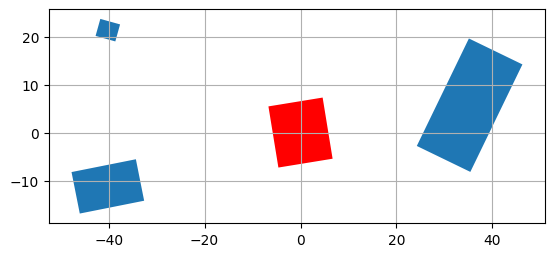

In [146]:
from shapely import from_wkt

rotated_rectangle = from_wkt(spec_old.rotated_rectangle)
neighbor_polys = [from_wkt(poly) for poly in spec_old.neighbor_polys]
import geopandas as gpd
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ne = gpd.GeoSeries(neighbor_polys)
bu = gpd.GeoSeries(rotated_rectangle)
ne.translate(xoff=-bu.iloc[0].centroid.x, yoff=-bu.iloc[0].centroid.y).plot(ax=ax)
bu.translate(xoff=-bu.iloc[0].centroid.x, yoff=-bu.iloc[0].centroid.y).plot(
    ax=ax, color="red"
)
ax.grid()

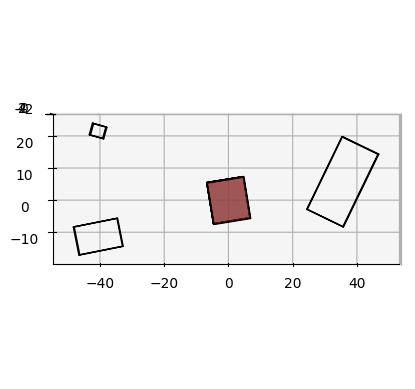

In [147]:
from geomeppy.view_geometry import _get_collection, _get_surfaces

surfaces = _get_surfaces(my_idf)
# set up the collections
walls = _get_collection("wall", surfaces, 0.5, facecolor="lightyellow")
floors = _get_collection("floor", surfaces, 0.5, facecolor="dimgray")
roofs = _get_collection("roof", surfaces, 0.5, facecolor="firebrick")
windows = _get_collection("window", surfaces, 0.5, facecolor="cornflowerblue")
shading = _get_collection("shading", surfaces, 1, facecolor="darkolivegreen")

ax = plt.axes(projection="3d")
ax.add_collection3d(floors)
ax.add_collection3d(walls)
ax.add_collection3d(roofs)
ax.add_collection3d(windows)
ax.add_collection3d(shading)
ax.view_init(elev=90, azim=-90)
ax.set_aspect("equal")
# set the view to be in plane, i.e. from above


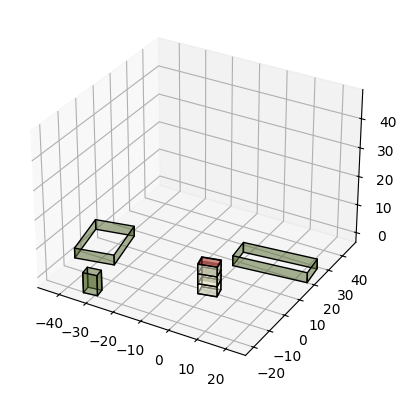

In [136]:
fig, ax = my_idf.view_model()
